In [11]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../../../../SCS')
sys.path.append('../../../scripts/')

from scs import preprocessing, transformer, postprocessing

import math
import os

from seg_utils import bin_2d_data
from paths import get_data_paths

from src import scs
import pandas as pd
import matplotlib.pyplot as plt
import spateo as st
import skimage.io as sio
import skmisc
from skimage import measure
import numpy as np

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_FOLDER = get_data_paths('../../../../data_mapping.yml')['human_ovarian_cancer']
OUT_FOLDER = f'{DATA_FOLDER}/seg_method_results/scs'
INPUT_FOLDER = f'{OUT_FOLDER}/input/'
IMG_PATH = f'{INPUT_FOLDER}/dapi.tif'
BIN_PATH = f'{INPUT_FOLDER}/bin_df_subset.tsv'

os.makedirs(INPUT_FOLDER, exist_ok=True)

In [3]:
pixel_scale = 0.2125
pixel_step = 5
pixel_step * pixel_scale

1.0625

## Prepare data

In [4]:
df = pd.read_parquet(f'{DATA_FOLDER}/subset/transcripts.parquet')
df.rename(
    columns={'x_location': 'x', 'y_location': 'y', 'z_location': 'z', 'feature_name': 'gene'},
    inplace=True
)
df[['x', 'y', 'z']] /= 0.2125

df.head()

,transcript_id,cell_id,overlaps_nucleus,gene,x,y,z,qv,fov_name,nucleus_distance,codeword_index,codeword_category,is_gene
132387431,281951718555201,mmpmbecc-1,0,A2ML1,40144.191406,21640.734375,112.573524,40.0,G15,0.000000,14663,predesigned_gene,True
132387432,281951718555748,bnplodci-1,1,A2ML1,40373.601562,22323.308594,95.294113,40.0,G15,0.000000,14663,predesigned_gene,True
132387433,281951718433855,mmljnhlf-1,0,AAMP,40318.160156,21698.087891,108.088234,40.0,G15,0.234375,2394,predesigned_gene,True
132387434,281951718267364,bnpmabda-1,0,AAMP,40323.011719,22330.367188,104.411758,40.0,G15,0.359375,2394,predesigned_gene,True
132387435,281951718434656,bnmcjpdd-1,1,AAMP,40467.203125,22008.380859,112.352936,40.0,G15,0.000000,2394,predesigned_gene,True


In [24]:
dapi_img = sio.imread(f'{DATA_FOLDER}/morphology_focus/morphology_focus_0000.ome.tif')[:,:,0]

In [9]:
x_min, x_max = (df.x.min(), df.x.max())
y_min, y_max = (df.y.min(), df.y.max())

In [ ]:
x_min, y_min

In [25]:
dapi_img = np.array(dapi_img[int(y_min):int(y_max), int(x_min):int(x_max)])
dapi_img.shape

(2353, 2352)

In [26]:
df.x -= x_min
df.y -= y_min

(471, 471)

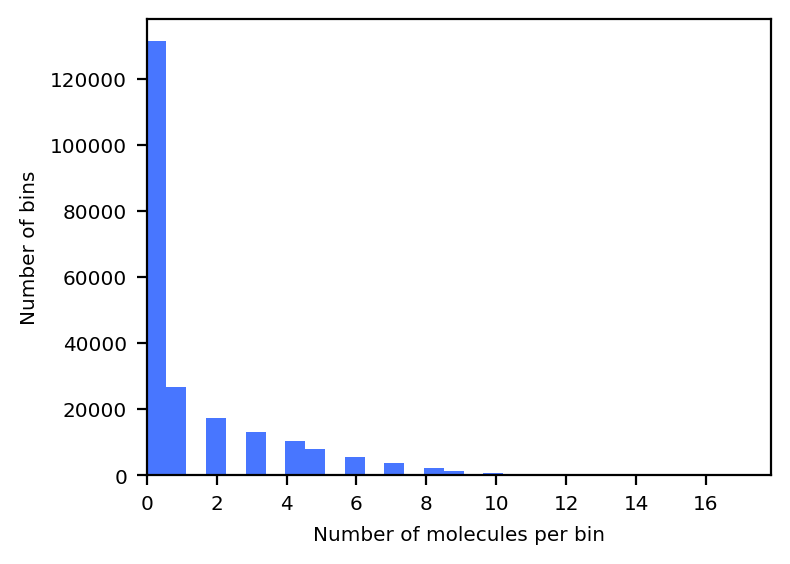

In [27]:
hist_info = bin_2d_data(df['x'], df['y'], step=pixel_step)
plt.figure(figsize=(4, 3))
plt.hist(hist_info[0].flatten(), bins=30);
plt.xlabel('Number of molecules per bin'); plt.ylabel('Number of bins');
plt.xlim(0, None);

hist_info[0].shape

In [28]:
df['row'] = hist_info[-2]
df['column'] = hist_info[-1]

# SCS assume that the data is indexed (x, y), so rows are named `x`
bin_df =(
    df.groupby(['gene', 'row', 'column']).
    size().
    sort_values(ascending=False).
    reset_index().
    rename(columns={0: 'MIDCounts', 'gene': 'gene_ID', 'row': 'y', 'column': 'x'})
)[['gene_ID', 'x', 'y', 'MIDCounts']]

bin_df.head()

,gene_ID,x,y,MIDCounts
0,DeprecatedCodeword_2163,192,361,5
1,DeprecatedCodeword_11713,126,291,5
2,EEF1G,219,358,5
3,DeprecatedCodeword_2163,163,276,5
4,DeprecatedCodeword_2163,264,12,5


In [29]:
(bin_df.x.min(), bin_df.x.max()), (bin_df.y.min(), bin_df.y.max())

((0, 470), (0, 470))

In [30]:
sio.imsave(IMG_PATH, dapi_img[::pixel_step, ::pixel_step])
bin_df.to_csv(BIN_PATH, index=False, sep='\t')

## Run SCS

In [17]:
from src import preprocessing, transformer, postprocessing
import scanpy as sc

In [ ]:
preprocessing.preprocess(
    BIN_PATH, IMG_PATH, False, None, 0, 0, patchsize=0, bin_size=5,
    n_neighbor=50, watershed_labels=None, out_path=OUT_FOLDER
)

|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.
|-----> <select> unspliced layer in AnnData Object
|-----> <select> stain layer in AnnData Object
|-----> <select> unspliced layer in AnnData Object
fig folder exists
|-----> <select> stain layer in AnnData Object
|-----> Constructing nuclei mask from staining image.


In [ ]:
transformer.train(0, 0, 0, 100, 0.0625, out_path=OUT_FOLDER)

In [ ]:
cell_labels = postprocessing.postprocess(0, 0, 0, 3, 15, out_path=OUT_FOLDER, figsize=(10, 10))
cell_labels.shape

In [ ]:
cell_labels.max()